## A1: Data Curation: Wikipedia Page Views
### Priyanka Bijlani
### October 8, 2020

This notebook walks through the acquistion, processing and analysis of Wikipedia pageview data in a detailed format.

### Acquiring the data
The first step in generating a chart for Wikipedia page views is to access the data and bring it into this notebook. The method we will employ to access the data is via Wikipedia REST API calls that are publicly available here: https://www.mediawiki.org/wiki/REST_API.

The API documentation explains how to access the endpoints that provide json responses. To process the data, we must import two modules that allow processing of json responses. These are shown in the cell below.

In [1]:
import json
import requests

The cell below defines the two API endpoints defined in the API documentation. The legacy API that provides pagecount is defined first and the pageviews API is defined next. 

There are parameters in the string defining the call in curly brackets. These will be populated later in the notebook when the API parameters are defined.

In [2]:
#legacy API
endpoint_pagecount = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

#new API
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

The parameters used in the API endpoints are defined below. We need to create 7 different parameter defintions, one for each of the query types(api-type, access-type). We can adjust the parameters to gather the data we need. Use the provided example notebook as a template for the parameters body: http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb. See cell below for parameter bodies defined for all 7 query types.

For the legacy pagecounts API, we need to adjust:
    - access-site: all-sites/desktop-site/mobile-site
    - start: 2007120100
    - end: 2020080100
For the new pageviews API, we need to adjust:
    - access: all-access/desktop/mobile-web/mobile-app
    - agent: user
    - start: 2015070100
    - end: 2020080100

In [3]:
#legacy API for 'all' types of sites
all_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "all-sites",
                 "granularity" : "monthly",
                 "start" : "2007120100", 
                 "end" : "2020080100"
                    }
#legacy API for 'desktop' types of sites
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2020080100"
                    }
#legacy API for 'mobile' types of sites
mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2020080100"
                    }

#new API for 'all' types of sites
all_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "all-access",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2020080100'
                        }
#new API for 'desktop' types of sites
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2020080100'
                        }
#new API for 'mobile-web' types of sites
mobileweb_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2020080100'
                        }
#new API for 'mobile-app' types of sites
mobileapp_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2020080100'
                        }

Before calling the APIs, define a method that returns the response of the call as shown below. The definition takes two inputs that are unique to each call, endpoint and parameter. The endpoint is unique to the API (legacy pagecount or new pageviews). The parameters are unique to the query type(mobile/desktop/all).

In [4]:
#definition for api call
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters))
    response = call.json()
    
    return response

Call each API (total 7) and save thier response in a variable that is unique to the response as shown below.

In [5]:
all_monthly_legacy = api_call(endpoint_pagecount, all_params_legacy)
desktop_monthly_legacy = api_call(endpoint_pagecount, desktop_params_legacy)
mobile_monthly_legacy = api_call(endpoint_pagecount, mobile_params_legacy)
all_monthly_pageviews = api_call(endpoint_pageviews, all_params_pageviews)
desktop_monthly_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews)
mobileweb_monthly_pageviews = api_call(endpoint_pageviews, mobileweb_params_pageviews)
mobileapp_monthly_pageviews = api_call(endpoint_pageviews, mobileapp_params_pageviews)

Save each response into a json file as shown below. The filename should follow the convention: apiname_accesstype_firstmonth-lastmonth.json

In [6]:
with open('pagecounts_desktop-site_200712-202008.json', 'w') as outfile:
    json.dump(desktop_monthly_legacy, outfile)
    
with open('pagecounts_mobile-site_200712-202008.json', 'w') as outfile:
    json.dump(mobile_monthly_legacy, outfile)
    
with open('pageviews_desktop_201507-202008.json', 'w') as outfile:
    json.dump(desktop_monthly_pageviews, outfile)
    
with open('pageviews_mobile-web_201507-202008.json', 'w') as outfile:
    json.dump(mobileweb_monthly_pageviews, outfile)
    
with open('pageviews_mobile-app_201507-202008.json', 'w') as outfile:
    json.dump(mobileapp_monthly_pageviews, outfile)

### Processing the data
To process the data, we will primarily use pandas within python. The main processing steps we need to do are combining the responses into a single file with a column for each query type. Also, we need to combine the mobile-web and mobile-app data into a single column. 

The first step in order to process the data is to import the pandas package as shown below.

In [7]:
import pandas as pd

In order to use the API responses for further processing, we must convert them into dataframes. The definition below converts each API call from above into a dataframe. This definition takes in two inputs that are unique to each call. Items refers to the response of the call and key refers to the the key in each call that is either called 'views' or 'count.' The steps are as shown:
1. Create an empty dataframe
2. Retrieve the timestamp
3. Retrieve the counts/views
4. Append the timestamp and views to the dataframe
5. Return the populated datafrome with columns, Timestamp and Views

In [8]:
 def makedf(items, key):   
    timestamp_list = []
    views_list = []
    df = pd.DataFrame()
    for i in range(0,len(items)):
        timestamp = items[i]['timestamp']
        views = items[i][key]
        timestamp_list.append(timestamp)
        views_list.append(views)
    df['Timestamp'] = timestamp_list
    df['Views'] = views_list
    return df

Call the method 'makedf' on each response to generate 7 dataframes. The legacy pagecount API has key=count and the new pageviews API has key='views.'

In [9]:
pagecount_all = makedf(all_monthly_legacy['items'], 'count')
pagecount_desktop = makedf(desktop_monthly_legacy['items'], 'count')
pagecount_mobile = makedf(mobile_monthly_legacy['items'], 'count')
pageviews_all = makedf(all_monthly_pageviews['items'], 'views')
pageviews_desktop = makedf(desktop_monthly_pageviews['items'], 'views')
pageviews_mobileweb = makedf(mobileweb_monthly_pageviews['items'], 'views')
pageviews_mobileapp = makedf(mobileapp_monthly_pageviews['items'], 'views')

In order to generate a single csv with the required columns, we need to merge all the dataframes based on timestamp. All the merging takes place in the cells below. 

1. Merge legacy pagecount desktop with legacy pagecount mobile
2. Filter the dataframe to only have the required columns
3. Merge the dataframe created in step 1 with legacy pagecount all dataframe
4. Filter the dataframe to only have the required columns
5. Merge pageviews mobileweb with pageviews mobile app dataframe
6. Add the mobileapp and mobileweb dataframes to combine into single mobile dataframe.
7. Filter the dataframe to only have the required columns
8. Merge pageviews mobile with pageviews desktop dataframe
9. Filter the dataframe to only have the required columns
10. Merge pageviews mobile/desktop with pageviews all dataframe
11. Filter the dataframe to only have the required columns
12. Merge pagecount and pageviews dataframes together to produce final dataframe
13. Create a copy of final_df to use later for graphing purposes.

In [10]:
df = pagecount_desktop.merge(pagecount_mobile, on='Timestamp', how='outer') #step 1
df['pagecount_desktop_views'] = df['Views_x']
df['pagecount_mobile_views'] = df['Views_y']
df = df[['Timestamp','pagecount_desktop_views','pagecount_mobile_views']] #step 2

df_legacy = df.merge(pagecount_all, on='Timestamp', how='outer') #step 3
df_legacy['pagecount_all_views'] = df_legacy['Views']
df_legacy = df_legacy[['Timestamp','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views']] #step 4

df_pageviews = pageviews_mobileweb.merge(pageviews_mobileapp, on='Timestamp', how='outer') #step 5
df_pageviews['pageview_mobile_views'] = df_pageviews['Views_x'] + df_pageviews['Views_y'] #step 6
df_pageviews = df_pageviews[['Timestamp','pageview_mobile_views']] #step 7

df_pageviews = df_pageviews.merge(pageviews_desktop, on='Timestamp') #step 8
df_pageviews['pageview_desktop_views'] = df_pageviews['Views']
df_pageviews = df_pageviews[['Timestamp','pageview_desktop_views','pageview_mobile_views']] #step 9

df_pageviews_all = df_pageviews.merge(pageviews_all, how='outer', on='Timestamp') #step 10
df_pageviews_all['pageview_all_views'] = df_pageviews_all['Views']
df_pageviews_all = df_pageviews_all[['Timestamp','pageview_all_views','pageview_desktop_views','pageview_mobile_views']] #step 11

final_df = df_legacy.merge(df_pageviews_all, on='Timestamp', how='outer') #step 12
full_df = final_df #step 13

The timestamp must be split into year and month. To achieve this, we can use the slice method in python. The final merged dataframe contains more columns than required, so filter to keep only the columns needed for the output csv.

In [11]:
final_df['year'] = final_df['Timestamp'].str.slice(stop=4) #slice timestamp to retrieve year
final_df['month'] = final_df['Timestamp'].str.slice(start=4,stop=6) #slice timestamp to retrieve month
final_df = final_df[['year', 'month', 'pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]

The nan values (nulls) in the dataframes must be filled with 0s in the csv. Use the fillna method in pandas to fill the NaN with 0 as shown below

In [12]:
final_df = final_df.fillna(0)
final_df #preview the dataframe

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
147,2020,03,0.000000e+00,0.000000e+00,0.0,8.098769e+09,3.412498e+09,4.686271e+09
148,2020,04,0.000000e+00,0.000000e+00,0.0,9.304115e+09,3.798373e+09,5.505742e+09
149,2020,05,0.000000e+00,0.000000e+00,0.0,8.309794e+09,3.078094e+09,5.231700e+09
150,2020,06,0.000000e+00,0.000000e+00,0.0,7.295304e+09,2.721329e+09,4.573975e+09


Generate a csv file using the filename defined: en-wikipedia_traffic_200712-202008.csv

In [13]:
final_df.to_csv('en-wikipedia_traffic_200712-202008.csv')

### Analyzing the data

To analyze the data, we must plot it as a time-series using the matplotlib library in python. The goal of graphing the dataframes is to see the span of the pageviews and pagecount over the years broken down into mobile/desktop/all types of queries. To achieve this, we must import matplotlib.pyplot using the statement below. 

In [14]:
import matplotlib.pyplot as plt

To plot the dataframes, we will use the full_df dataframe instead of final_df because it includes the timestamp column.

Convert timestamp (currently it is of type string) into a datetime using the method shown below. 

In [15]:
full_df['Timestamp'] = pd.to_datetime(full_df['Timestamp'], format='%Y%m%d%H')

To plot the dataframe, follow the steps below:
1. Define size of the graph.
2. Label the axes.
3. Add gridlines.
4. Plot timestamp on the x-axis and each column on the y-axis separately. Use colors and linestypes to differentiate query/API type.
5. Add a legend.
6. Save the graph in png format.

The graph shown below shows the span of pageviews and pagecount over the years with a breakdown of mobile versus desktop.

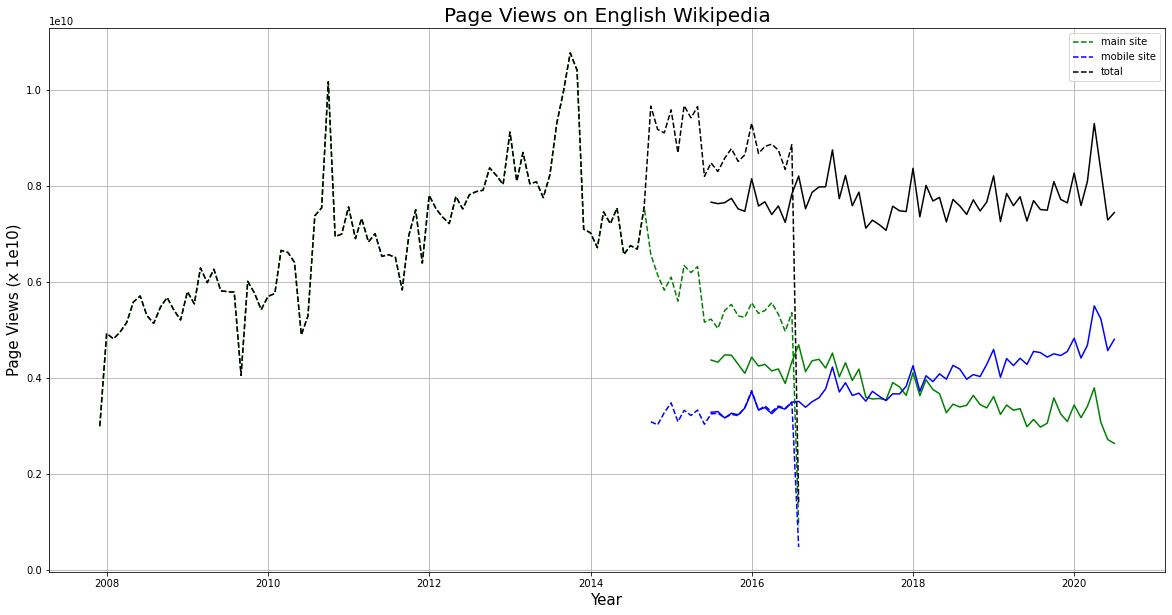

In [16]:
plt.figure(figsize=(20,10))
plt.title("Page Views on English Wikipedia", fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Page Views (x 1e10)', fontsize=15)
plt.grid()
plt.plot_date(full_df['Timestamp'], full_df['pagecount_desktop_views'], linestyle='--', marker='None', color='green', label='main site')
plt.plot_date(full_df['Timestamp'], full_df['pagecount_mobile_views'], linestyle='--', marker='None', color='blue',label='mobile site')
plt.plot_date(full_df['Timestamp'], full_df['pagecount_all_views'], linestyle='--', marker='None', color='black', label='total')
plt.plot_date(full_df['Timestamp'], full_df['pageview_all_views'], linestyle='-', marker='None', color='black')
plt.plot_date(full_df['Timestamp'], full_df['pageview_desktop_views'], linestyle='-', marker='None', color='green')
plt.plot_date(full_df['Timestamp'], full_df['pageview_mobile_views'], linestyle='-', marker='None', color='blue')
plt.legend()
plt.savefig('WikipediaPageViews.png')